In [44]:
# Import necessary libraries
import geopandas as gpd
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score 
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import seaborn as sns

In [45]:
train_data = pd.read_csv('./datasets/processed_train.csv')
test_data = pd.read_csv('./datasets/processed_test.csv')

In [46]:
test_data = test_data.rename(columns = {'distance_to_nearest_fault':'distance_to_nearest_fault_zones'})

In [47]:
train_data


,Unnamed: 0,Target,ID,geometry,dtm,average_precipitation,perc_precipitation,eastness,northness,hillshade,...,distance_to_nearest_river,distance_to_nearest_fault_zones,centroid,latitude,longitude,area,perimeter,bounding_box,aspect_ratio,convex_hull
0,0,1,ID_000001,MULTIPOLYGON (((607152.9161999999 5124458.3954...,1499.4082,0.154537,0.265434,-0.816495,-0.577352,-74,...,42.258153,3468.288421,POINT (607174.0771399431 5124482.765102093),5.124483e+06,607174.077140,3388.029832,302.726228,"POLYGON ((607117.6665000003 5124457.8957, 6072...",0.118501,"POLYGON ((607137.7912999997 5124457.8957, 6071..."
1,1,1,ID_000002,"MULTIPOLYGON (((611957.1014 5131543.0714, 6119...",2369.4084,0.134484,0.218065,0.992943,0.118594,-106,...,416.844630,662.149764,POINT (611796.3079673459 5131481.270119999),5.131481e+06,611796.307967,18752.313644,1376.367272,"POLYGON ((611602.4818000002 5131360.0877, 6119...",0.119257,"POLYGON ((611602.4818000002 5131360.0877, 6116..."
2,2,1,ID_000003,MULTIPOLYGON (((612895.9661999997 5130875.5646...,2103.7690,0.134484,0.218065,0.713229,0.700931,-108,...,0.000000,0.000000,POINT (613139.6068859898 5131228.87917981),5.131229e+06,613139.606886,41653.464781,1657.494005,"POLYGON ((612858.4665999999 5130875.065099999,...",0.119536,"POLYGON ((612880.7164000003 5130875.065099999,..."
3,3,1,ID_000004,"MULTIPOLYGON (((609366.8822999997 5131249.149,...",2484.2866,0.143612,0.243227,0.675394,-0.737457,-127,...,205.885774,535.782979,POINT (609347.4880599163 5131305.222482853),5.131305e+06,609347.488060,5466.464177,335.413248,"POLYGON ((609306.5077 5131248.6491, 609386.757...",0.118757,"POLYGON ((609361.7573999995 5131248.6491, 6093..."
4,4,1,ID_000005,MULTIPOLYGON (((611814.8477999996 5132646.0391...,2624.2622,0.138958,0.243466,0.850295,-0.526306,58,...,82.533645,220.274205,POINT (611761.1333471948 5132712.759155421),5.132713e+06,611761.133347,6297.649033,448.994024,"POLYGON ((611660.8492999999 5132644.5393, 6118...",0.119199,"POLYGON ((611808.4729000004 5132644.5393, 6117..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12135,12135,0,ID_012136,"MULTIPOLYGON (((540821.8694 5097076.2481, 5408...",2070.0000,0.284925,0.427346,-0.707107,-0.707107,-76,...,0.000000,0.000000,POINT (540783.5248959785 5097145.463917697),5.097145e+06,540783.524896,9325.000000,880.000000,"POLYGON ((540721.8694 5097076.2481, 540841.869...",0.106105,"POLYGON ((540816.8694 5097076.2481, 540726.869..."
12136,12136,0,ID_012137,"MULTIPOLYGON (((542231.8694 5096911.2481, 5422...",1858.0900,0.285867,0.454944,0.987688,0.156435,-75,...,1169.573999,0.000000,POINT (542179.7371905224 5096989.885785585),5.096990e+06,542179.737191,19332.825307,930.167189,"POLYGON ((542101.8694 5096886.2481, 542281.869...",0.106389,"POLYGON ((542186.8694 5096886.2481, 542181.869..."
12137,12137,0,ID_012138,"MULTIPOLYGON (((542636.8694 5096726.2481, 5426...",2043.4340,0.285867,0.454944,-0.907157,0.420793,-29,...,1592.957765,239.927811,POINT (542594.9706377112 5096728.094348592),5.096728e+06,542594.970638,8748.167418,701.144940,"POLYGON ((542546.8694 5096641.2481, 542641.869...",0.106467,"POLYGON ((542606.8694 5096641.2481, 542591.869..."
12138,12138,0,ID_012139,"MULTIPOLYGON (((541576.8694 5096291.2481, 5415...",2254.3700,0.287747,0.456125,0.987688,0.156435,-75,...,526.553029,0.000000,POINT (541684.9564412776 5096289.988514547),5.096290e+06,541684.956441,25097.755508,1103.417454,"POLYGON ((541576.8694 5096211.2481, 541801.869...",0.106311,"POLYGON ((541611.8694 5096211.2481, 541587.260..."


In [48]:
train_data.describe()

,Unnamed: 0,Target,dtm,average_precipitation,perc_precipitation,eastness,northness,hillshade,roughness,slope_rad,...,TRI,aspect_degree,distance_to_nearest_road,distance_to_nearest_river,distance_to_nearest_fault_zones,latitude,longitude,area,perimeter,aspect_ratio
count,12140.000000,12140.000000,12140.000000,12077.000000,12077.000000,12140.000000,12140.000000,12140.000000,12140.000000,12140.000000,...,12140.000000,12140.000000,12140.000000,12140.000000,12140.000000,1.214000e+04,12140.000000,1.214000e+04,12140.000000,12140.000000
mean,6069.500000,0.863509,1943.395744,0.145851,0.267526,0.035786,-0.105230,-10.582702,-0.803899,0.368607,...,-6.551990,-22.934283,1969.521563,974.522739,580.217596,5.129458e+06,574064.734670,4.211830e+04,1420.120085,0.111933
std,3504.660469,0.343323,655.069278,0.049015,0.101768,0.717565,0.687624,74.987064,301.165001,5.272784,...,300.940911,1410.969209,1739.020964,1035.991241,878.708646,1.752327e+04,26924.729608,4.441273e+05,6454.037865,0.005093
min,0.000000,0.000000,0.000000,0.015400,0.043587,-1.000000,-1.000000,-128.000000,-9999.000000,-174.515470,...,-9999.000000,-9999.000000,0.000000,0.000000,0.000000,5.095686e+06,519125.804924,2.425122e-01,7.616213,0.100938
25%,3034.750000,1.000000,1547.244950,0.123021,0.204066,-0.690943,-0.786822,-75.000000,5.037720,0.379142,...,1.552334,91.139645,358.945329,158.160593,65.176391,5.114817e+06,552066.055573,3.491695e+03,338.585852,0.108038
50%,6069.500000,1.000000,2090.110100,0.147981,0.258750,0.071038,-0.166190,-24.000000,7.895752,0.558450,...,2.416412,173.198245,1692.589654,721.809078,277.562273,5.129500e+06,580672.205560,7.606654e+03,607.724721,0.113037
75%,9104.250000,1.000000,2433.238525,0.173198,0.327136,0.758094,0.535895,60.000000,10.429138,0.681385,...,3.147030,251.844890,3126.774411,1474.850963,695.845887,5.143966e+06,594747.738982,1.678998e+04,1129.951556,0.115704
max,12139.000000,1.000000,3809.954300,0.287747,0.656016,1.000000,1.000000,127.000000,105.049930,1.469594,...,38.904984,359.962300,9919.507863,8959.595442,7396.649444,5.165026e+06,624455.762014,3.989145e+07,371302.694993,0.121513


In [49]:
test_data.describe()

,Unnamed: 0,dtm,average_precipitation,perc_precipitation,eastness,northness,hillshade,roughness,slope_rad,TPI,TRI,aspect_degree,distance_to_nearest_road,distance_to_nearest_river,distance_to_nearest_fault_zones,latitude,longitude,area,perimeter,aspect_ratio
count,40000.00000,40000.000000,39907.000000,39907.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,4.000000e+04,40000.000000,40000.0,40000.0,40000.000000
mean,19999.50000,1436.691984,0.140449,0.251514,0.099720,-0.031418,-40.735700,4.078505,0.282634,-0.547254,0.890711,-711.536118,1190.067921,879.097546,921.060889,5.129106e+06,568325.619179,0.0,0.0,0.110798
std,11547.14972,834.124808,0.043380,0.094815,0.745925,0.657792,65.620792,70.995638,1.269822,70.705343,70.737043,2878.040722,1495.296210,1014.031921,1081.392087,1.689140e+04,27300.533277,0.0,0.0,0.005188
min,0.00000,0.000000,0.015400,0.043587,-1.000000,-1.000000,-128.000000,-9999.000000,-174.515470,-9999.000000,-9999.000000,-9999.000000,0.015266,0.028123,0.008678,5.096222e+06,519352.702561,0.0,0.0,0.101023
25%,9999.75000,497.032000,0.125620,0.198248,-0.679266,-0.667432,-77.000000,0.337944,0.020944,-0.061401,0.104794,72.419750,104.761743,214.518900,274.742120,5.112793e+06,543667.656991,0.0,0.0,0.106368
50%,19999.50000,1680.058500,0.146521,0.238198,0.200289,0.047060,-73.000000,2.970474,0.227022,-0.000122,0.911324,159.845525,430.605902,527.938658,599.804444,5.127879e+06,568711.850670,0.0,0.0,0.111187
75%,29999.25000,2107.264375,0.164642,0.305086,0.880214,0.546665,-19.000000,7.373993,0.525216,0.036865,2.243759,257.391607,1892.679991,1212.657860,1132.744238,5.144614e+06,591522.676636,0.0,0.0,0.115085
max,39999.00000,3776.991700,0.287747,0.642151,1.000000,1.000000,127.000000,125.069610,1.473626,36.847656,39.459840,359.998840,9521.115542,9376.057683,7908.537587,5.165358e+06,624015.983945,0.0,0.0,0.121272


In [50]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12140 entries, 0 to 12139
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       12140 non-null  int64  
 1   Target                           12140 non-null  int64  
 2   ID                               12140 non-null  object 
 3   geometry                         12140 non-null  object 
 4   dtm                              12140 non-null  float64
 5   average_precipitation            12077 non-null  float64
 6   perc_precipitation               12077 non-null  float64
 7   eastness                         12140 non-null  float64
 8   northness                        12140 non-null  float64
 9   hillshade                        12140 non-null  int64  
 10  roughness                        12140 non-null  float64
 11  slope_rad                        12140 non-null  float64
 12  TPI               

Replacing the null values[-9999] with 0

In [51]:
train_data['roughness'] = np.where(train_data['roughness'] == -9999.0, 0,  train_data['roughness'])
train_data['slope_rad'] = np.where(train_data['slope_rad'] == -9999.0, 0,  train_data['slope_rad'])
train_data['TPI'] = np.where(train_data['TPI'] == -9999.0, 0,  train_data['TPI'])
train_data['TRI'] = np.where(train_data['TRI'] == -9999.0, 0,  train_data['TRI'])

In [52]:
test_data['roughness'] = np.where(test_data['roughness'] == -9999.0, 0,  test_data['roughness'])
test_data['slope_rad'] = np.where(test_data['slope_rad'] == -9999.0, 0,  test_data['slope_rad'])
test_data['TPI'] = np.where(test_data['TPI'] == -9999.0, 0,  test_data['TPI'])
test_data['TRI'] = np.where(test_data['TRI'] == -9999.0, 0,  test_data['TRI'])

In [53]:
train_data.columns

Index(['Unnamed: 0', 'Target', 'ID', 'geometry', 'dtm',
       'average_precipitation', 'perc_precipitation', 'eastness', 'northness',
       'hillshade', 'roughness', 'slope_rad', 'TPI', 'TRI', 'aspect_degree',
       'distance_to_nearest_road', 'distance_to_nearest_river',
       'distance_to_nearest_fault_zones', 'centroid', 'latitude', 'longitude',
       'area', 'perimeter', 'bounding_box', 'aspect_ratio', 'convex_hull'],
      dtype='object')

### Visualization of features

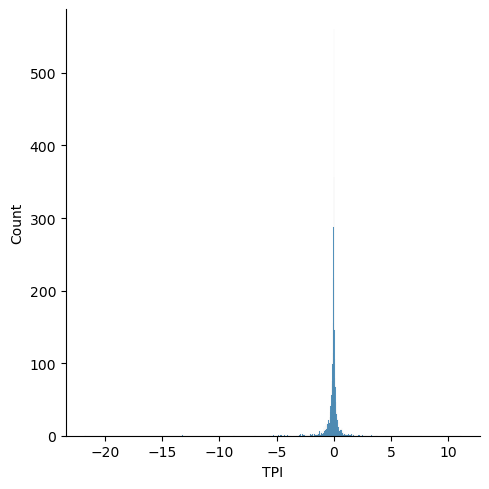

In [54]:
sns.displot(train_data.sample(4000)['TPI'])
plt.show();

As seen in the visualization above, this is a normal distribution with a few outliers

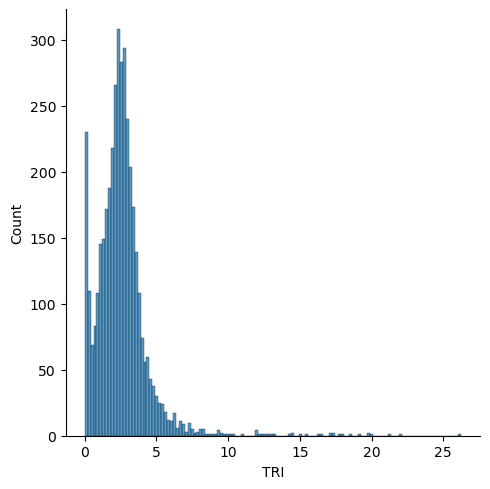

In [55]:
sns.displot(train_data.sample(4000)['TRI'])
plt.show();

As seen in the visualization above, this is a right-skewed distribution 

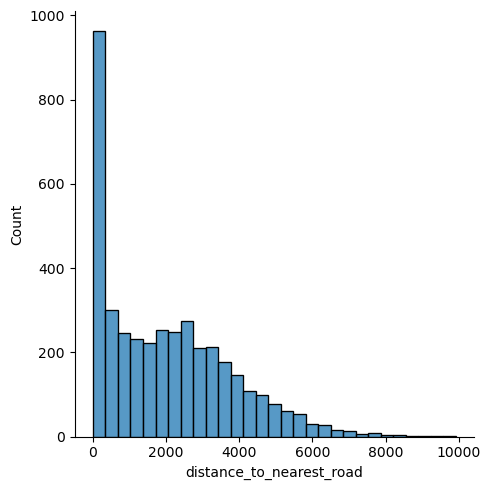

In [56]:
sns.displot(train_data.sample(4000)['distance_to_nearest_road'])
plt.show();

As seen in the visualization above, this is a right-skewed distribution 

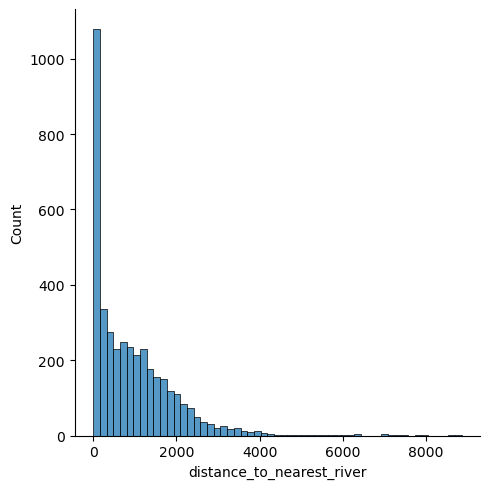

In [57]:
sns.displot(train_data.sample(4000)['distance_to_nearest_river'])
plt.show();


As seen in the visualization above, this is a right-skewed distribution 

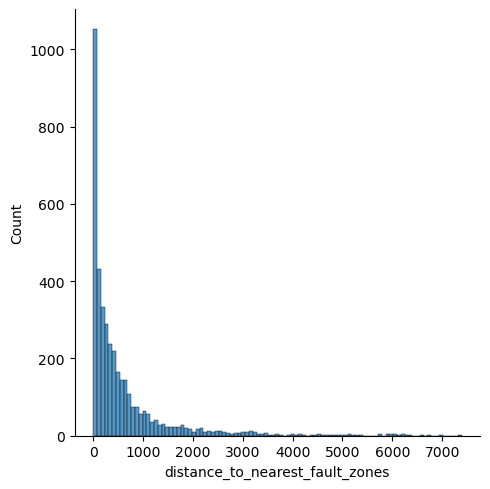

In [58]:

sns.displot(train_data.sample(4000)['distance_to_nearest_fault_zones'])
plt.show();


As seen in the visualization above, this is a right-skewed distribution 

In [59]:
#creating the submission dataframe
sub = pd.DataFrame()
sub['ID'] = test_data['ID']

In [60]:
#dropping irrelevant columns
train_data = train_data.drop(columns = ['geometry','centroid','bounding_box','convex_hull','Unnamed: 0','area', 'perimeter'])
test_data = test_data.drop(columns = ['geometry','centroid','bounding_box','convex_hull','Unnamed: 0','area', 'perimeter'])

In [61]:
train_data['Target'].value_counts()

1    10483
0     1657
Name: Target, dtype: int64

In [62]:
test_data

,ID,dtm,average_precipitation,perc_precipitation,eastness,northness,hillshade,roughness,slope_rad,TPI,TRI,aspect_degree,distance_to_nearest_road,distance_to_nearest_river,distance_to_nearest_fault_zones,latitude,longitude,aspect_ratio
0,ID_000001,1303.1439,0.226309,0.335290,0.889065,0.457782,99,11.834473,0.726230,-0.289673,3.459900,62.755936,532.189622,1000.917702,84.145427,5.103652e+06,541862.335807,0.106171
1,ID_000002,2743.5247,0.175368,0.461412,0.726184,-0.687500,42,10.106689,0.622848,-0.038818,2.576111,133.432570,4006.930094,1649.903253,102.287223,5.131799e+06,566456.495993,0.110382
2,ID_000003,1535.2539,0.194696,0.383039,-0.527985,0.849254,-10,8.464844,0.550582,0.034424,2.354599,328.130600,773.740503,584.534148,827.982355,5.109016e+06,584598.971887,0.114425
3,ID_000004,1938.3684,0.170589,0.214643,-0.666372,0.745620,-8,9.158691,0.551983,-0.163818,2.562866,318.212340,5840.225672,436.181599,791.679670,5.125941e+06,542414.162385,0.105817
4,ID_000005,2013.9377,0.173891,0.294433,0.741497,-0.670956,1,21.929200,1.038145,-0.793945,6.329514,132.140900,2461.286859,2311.669383,1813.340365,5.133371e+06,532099.143919,0.103655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,ID_039996,1204.1470,0.159315,0.377356,-0.965510,0.260364,-56,1.818970,0.132465,-0.249390,0.565750,285.091670,6.852835,191.197953,829.073174,5.146469e+06,605509.422777,0.117655
39996,ID_039997,1891.8700,0.156467,0.242401,0.987688,0.156435,-75,0.000000,0.000000,0.000000,0.000000,-9999.000000,279.211348,1090.397403,1437.766857,5.147833e+06,526815.198540,0.102337
39997,ID_039998,1891.8700,0.171749,0.286767,0.987688,0.156435,-75,0.000000,0.000000,0.000000,0.000000,-9999.000000,293.134691,898.942591,1182.744639,5.147471e+06,526873.189669,0.102356
39998,ID_039999,2015.1248,0.253332,0.526724,-0.378801,0.925478,-41,3.188599,0.239213,0.024658,0.962372,337.740600,4489.687645,695.121443,23.201835,5.101122e+06,569507.853816,0.111644


### Spliting

In [63]:
X = train_data.drop(columns = ['Target','ID'])
y = train_data['Target']
test_data = test_data.drop('ID',axis=1)

In [64]:
#using the imblearn package to oversample
rus = RandomOverSampler(random_state = 42)

In [65]:
X,y= rus.fit_resample(X,y)

In [66]:
sc  = StandardScaler()

### Training with StratifiedKFolds

In [67]:
# Define the number of folds
n_splits = 3  # You can adjust this as needed

# Initialize the StratifiedKFold cross-validator
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize arrays to store metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []
val_fold_predictions = []
test_fold_predictions = []

# Loop over the folds
for train_index, val_index in skf.split(X, y):
    # Split the data into training and validation sets for this fold
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_val, y_val = X.iloc[val_index], y.iloc[val_index]
    

    X_train = sc.fit_transform(X_train)
    X_val = sc.transform(X_val)
    test_data_scaled = sc.transform(test_data)

    # Initialize and train your classifier
    classifier =CatBoostClassifier(n_estimators=950, random_state=42)
    classifier.fit(X_train, y_train)

    # Predict on the validation set for this fold
    fold_predictions = classifier.predict(X_val)
    test_predictions = classifier.predict(test_data_scaled)
    
    
    val_fold_predictions.append(fold_predictions)
    test_fold_predictions.append(test_predictions)
    

    # Calculate metrics for this fold and store them
    accuracy_scores.append(accuracy_score(y_val, fold_predictions))
    precision_scores.append(precision_score(y_val, fold_predictions))
    recall_scores.append(recall_score(y_val, fold_predictions))
    f1_scores.append(f1_score(y_val, fold_predictions))
    roc_auc_scores.append(roc_auc_score(y_val, fold_predictions))
    
catboost_median_test_predictions = np.median(np.array(test_fold_predictions, dtype = int), axis=0)

# Calculate the mean of each metric across all folds
mean_accuracy = np.mean(accuracy_scores)
mean_precision = np.mean(precision_scores)
mean_recall = np.mean(recall_scores)
mean_f1 = np.mean(f1_scores)
mean_roc_auc = np.mean(roc_auc_scores)

# Now, mean_accuracy, mean_precision, mean_recall, mean_f1, and mean_roc_auc
# contain the mean values of the respective metrics across all folds.


Learning rate set to 0.033301
0:	learn: 0.6491266	total: 40.4ms	remaining: 38.4s
1:	learn: 0.6154882	total: 52ms	remaining: 24.7s
2:	learn: 0.5787502	total: 64.5ms	remaining: 20.4s
3:	learn: 0.5497982	total: 77.6ms	remaining: 18.4s
4:	learn: 0.5211446	total: 90.7ms	remaining: 17.1s
5:	learn: 0.4977531	total: 103ms	remaining: 16.2s
6:	learn: 0.4708582	total: 115ms	remaining: 15.5s
7:	learn: 0.4479868	total: 129ms	remaining: 15.2s
8:	learn: 0.4272643	total: 142ms	remaining: 14.8s
9:	learn: 0.4101283	total: 159ms	remaining: 14.9s
10:	learn: 0.3943677	total: 193ms	remaining: 16.5s
11:	learn: 0.3792054	total: 217ms	remaining: 17s
12:	learn: 0.3670195	total: 235ms	remaining: 16.9s
13:	learn: 0.3548955	total: 258ms	remaining: 17.2s
14:	learn: 0.3438519	total: 276ms	remaining: 17.2s
15:	learn: 0.3346285	total: 291ms	remaining: 17s
16:	learn: 0.3254543	total: 307ms	remaining: 16.9s
17:	learn: 0.3149327	total: 324ms	remaining: 16.8s
18:	learn: 0.3078524	total: 341ms	remaining: 16.7s
19:	learn: 0

168:	learn: 0.1380349	total: 3.03s	remaining: 14s
169:	learn: 0.1375475	total: 3.05s	remaining: 14s
170:	learn: 0.1371429	total: 3.06s	remaining: 14s
171:	learn: 0.1367414	total: 3.08s	remaining: 13.9s
172:	learn: 0.1363064	total: 3.09s	remaining: 13.9s
173:	learn: 0.1359473	total: 3.1s	remaining: 13.8s
174:	learn: 0.1357002	total: 3.12s	remaining: 13.8s
175:	learn: 0.1354631	total: 3.13s	remaining: 13.8s
176:	learn: 0.1352682	total: 3.14s	remaining: 13.7s
177:	learn: 0.1350144	total: 3.15s	remaining: 13.7s
178:	learn: 0.1347002	total: 3.17s	remaining: 13.6s
179:	learn: 0.1344054	total: 3.18s	remaining: 13.6s
180:	learn: 0.1342233	total: 3.19s	remaining: 13.6s
181:	learn: 0.1339168	total: 3.2s	remaining: 13.5s
182:	learn: 0.1336800	total: 3.22s	remaining: 13.5s
183:	learn: 0.1334328	total: 3.23s	remaining: 13.4s
184:	learn: 0.1331006	total: 3.24s	remaining: 13.4s
185:	learn: 0.1328854	total: 3.26s	remaining: 13.4s
186:	learn: 0.1325603	total: 3.27s	remaining: 13.4s
187:	learn: 0.132267

328:	learn: 0.1017960	total: 5.2s	remaining: 9.82s
329:	learn: 0.1016057	total: 5.21s	remaining: 9.8s
330:	learn: 0.1014555	total: 5.23s	remaining: 9.78s
331:	learn: 0.1013377	total: 5.24s	remaining: 9.76s
332:	learn: 0.1010924	total: 5.25s	remaining: 9.73s
333:	learn: 0.1009707	total: 5.27s	remaining: 9.71s
334:	learn: 0.1008538	total: 5.28s	remaining: 9.69s
335:	learn: 0.1007158	total: 5.29s	remaining: 9.67s
336:	learn: 0.1005798	total: 5.3s	remaining: 9.65s
337:	learn: 0.1003944	total: 5.32s	remaining: 9.63s
338:	learn: 0.1002222	total: 5.33s	remaining: 9.61s
339:	learn: 0.1000150	total: 5.34s	remaining: 9.58s
340:	learn: 0.0998363	total: 5.35s	remaining: 9.56s
341:	learn: 0.0996718	total: 5.37s	remaining: 9.54s
342:	learn: 0.0994884	total: 5.38s	remaining: 9.52s
343:	learn: 0.0992356	total: 5.39s	remaining: 9.5s
344:	learn: 0.0991294	total: 5.41s	remaining: 9.49s
345:	learn: 0.0988806	total: 5.42s	remaining: 9.47s
346:	learn: 0.0987108	total: 5.44s	remaining: 9.45s
347:	learn: 0.09

502:	learn: 0.0760792	total: 7.57s	remaining: 6.72s
503:	learn: 0.0759130	total: 7.58s	remaining: 6.71s
504:	learn: 0.0758122	total: 7.59s	remaining: 6.69s
505:	learn: 0.0756898	total: 7.61s	remaining: 6.68s
506:	learn: 0.0755231	total: 7.62s	remaining: 6.66s
507:	learn: 0.0754408	total: 7.63s	remaining: 6.64s
508:	learn: 0.0753794	total: 7.65s	remaining: 6.63s
509:	learn: 0.0752826	total: 7.67s	remaining: 6.62s
510:	learn: 0.0751674	total: 7.68s	remaining: 6.6s
511:	learn: 0.0750961	total: 7.69s	remaining: 6.58s
512:	learn: 0.0750000	total: 7.71s	remaining: 6.57s
513:	learn: 0.0749155	total: 7.72s	remaining: 6.55s
514:	learn: 0.0748445	total: 7.73s	remaining: 6.53s
515:	learn: 0.0747572	total: 7.75s	remaining: 6.51s
516:	learn: 0.0746378	total: 7.76s	remaining: 6.5s
517:	learn: 0.0745966	total: 7.77s	remaining: 6.48s
518:	learn: 0.0744335	total: 7.79s	remaining: 6.47s
519:	learn: 0.0742956	total: 7.8s	remaining: 6.45s
520:	learn: 0.0742177	total: 7.82s	remaining: 6.43s
521:	learn: 0.0

666:	learn: 0.0607904	total: 9.72s	remaining: 4.12s
667:	learn: 0.0607340	total: 9.74s	remaining: 4.11s
668:	learn: 0.0606432	total: 9.75s	remaining: 4.1s
669:	learn: 0.0606051	total: 9.77s	remaining: 4.08s
670:	learn: 0.0605018	total: 9.78s	remaining: 4.07s
671:	learn: 0.0604451	total: 9.79s	remaining: 4.05s
672:	learn: 0.0603675	total: 9.8s	remaining: 4.04s
673:	learn: 0.0603223	total: 9.81s	remaining: 4.02s
674:	learn: 0.0602680	total: 9.83s	remaining: 4s
675:	learn: 0.0601893	total: 9.84s	remaining: 3.99s
676:	learn: 0.0600761	total: 9.85s	remaining: 3.97s
677:	learn: 0.0600123	total: 9.87s	remaining: 3.96s
678:	learn: 0.0599374	total: 9.88s	remaining: 3.94s
679:	learn: 0.0598837	total: 9.89s	remaining: 3.93s
680:	learn: 0.0598198	total: 9.9s	remaining: 3.91s
681:	learn: 0.0597785	total: 9.92s	remaining: 3.9s
682:	learn: 0.0596796	total: 9.94s	remaining: 3.88s
683:	learn: 0.0596391	total: 9.95s	remaining: 3.87s
684:	learn: 0.0595605	total: 9.96s	remaining: 3.85s
685:	learn: 0.05952

832:	learn: 0.0499904	total: 11.9s	remaining: 1.67s
833:	learn: 0.0499323	total: 11.9s	remaining: 1.66s
834:	learn: 0.0498785	total: 11.9s	remaining: 1.64s
835:	learn: 0.0497823	total: 11.9s	remaining: 1.63s
836:	learn: 0.0497566	total: 11.9s	remaining: 1.61s
837:	learn: 0.0497097	total: 12s	remaining: 1.6s
838:	learn: 0.0496424	total: 12s	remaining: 1.58s
839:	learn: 0.0495710	total: 12s	remaining: 1.57s
840:	learn: 0.0494861	total: 12s	remaining: 1.55s
841:	learn: 0.0494273	total: 12s	remaining: 1.54s
842:	learn: 0.0493134	total: 12s	remaining: 1.53s
843:	learn: 0.0492625	total: 12s	remaining: 1.51s
844:	learn: 0.0492314	total: 12.1s	remaining: 1.5s
845:	learn: 0.0491598	total: 12.1s	remaining: 1.48s
846:	learn: 0.0491120	total: 12.1s	remaining: 1.47s
847:	learn: 0.0490878	total: 12.1s	remaining: 1.45s
848:	learn: 0.0490436	total: 12.1s	remaining: 1.44s
849:	learn: 0.0489738	total: 12.1s	remaining: 1.43s
850:	learn: 0.0489042	total: 12.1s	remaining: 1.41s
851:	learn: 0.0488322	total:

50:	learn: 0.1951191	total: 702ms	remaining: 12.4s
51:	learn: 0.1940636	total: 721ms	remaining: 12.4s
52:	learn: 0.1928889	total: 738ms	remaining: 12.5s
53:	learn: 0.1920416	total: 755ms	remaining: 12.5s
54:	learn: 0.1906623	total: 768ms	remaining: 12.5s
55:	learn: 0.1896457	total: 783ms	remaining: 12.5s
56:	learn: 0.1881488	total: 794ms	remaining: 12.4s
57:	learn: 0.1870338	total: 807ms	remaining: 12.4s
58:	learn: 0.1859415	total: 821ms	remaining: 12.4s
59:	learn: 0.1848253	total: 834ms	remaining: 12.4s
60:	learn: 0.1839015	total: 847ms	remaining: 12.3s
61:	learn: 0.1828783	total: 861ms	remaining: 12.3s
62:	learn: 0.1822311	total: 875ms	remaining: 12.3s
63:	learn: 0.1811419	total: 890ms	remaining: 12.3s
64:	learn: 0.1805979	total: 903ms	remaining: 12.3s
65:	learn: 0.1795078	total: 921ms	remaining: 12.3s
66:	learn: 0.1787262	total: 934ms	remaining: 12.3s
67:	learn: 0.1778081	total: 949ms	remaining: 12.3s
68:	learn: 0.1772352	total: 963ms	remaining: 12.3s
69:	learn: 0.1762971	total: 974

221:	learn: 0.1211484	total: 3.05s	remaining: 10s
222:	learn: 0.1208584	total: 3.07s	remaining: 10s
223:	learn: 0.1207133	total: 3.08s	remaining: 9.98s
224:	learn: 0.1203834	total: 3.09s	remaining: 9.97s
225:	learn: 0.1201593	total: 3.1s	remaining: 9.95s
226:	learn: 0.1199533	total: 3.12s	remaining: 9.93s
227:	learn: 0.1196960	total: 3.13s	remaining: 9.91s
228:	learn: 0.1195781	total: 3.14s	remaining: 9.9s
229:	learn: 0.1194148	total: 3.16s	remaining: 9.88s
230:	learn: 0.1191447	total: 3.17s	remaining: 9.87s
231:	learn: 0.1187636	total: 3.18s	remaining: 9.85s
232:	learn: 0.1185642	total: 3.19s	remaining: 9.83s
233:	learn: 0.1183881	total: 3.21s	remaining: 9.82s
234:	learn: 0.1181114	total: 3.22s	remaining: 9.8s
235:	learn: 0.1177674	total: 3.23s	remaining: 9.78s
236:	learn: 0.1176293	total: 3.25s	remaining: 9.77s
237:	learn: 0.1174175	total: 3.26s	remaining: 9.75s
238:	learn: 0.1172507	total: 3.28s	remaining: 9.75s
239:	learn: 0.1168998	total: 3.29s	remaining: 9.74s
240:	learn: 0.11671

393:	learn: 0.0884120	total: 5.42s	remaining: 7.65s
394:	learn: 0.0881932	total: 5.44s	remaining: 7.64s
395:	learn: 0.0879708	total: 5.45s	remaining: 7.63s
396:	learn: 0.0877785	total: 5.46s	remaining: 7.61s
397:	learn: 0.0876382	total: 5.48s	remaining: 7.6s
398:	learn: 0.0875335	total: 5.49s	remaining: 7.58s
399:	learn: 0.0873755	total: 5.51s	remaining: 7.57s
400:	learn: 0.0872465	total: 5.52s	remaining: 7.55s
401:	learn: 0.0870858	total: 5.53s	remaining: 7.54s
402:	learn: 0.0869315	total: 5.54s	remaining: 7.52s
403:	learn: 0.0868311	total: 5.56s	remaining: 7.51s
404:	learn: 0.0867145	total: 5.57s	remaining: 7.49s
405:	learn: 0.0866507	total: 5.58s	remaining: 7.48s
406:	learn: 0.0863656	total: 5.6s	remaining: 7.47s
407:	learn: 0.0862474	total: 5.61s	remaining: 7.45s
408:	learn: 0.0861883	total: 5.62s	remaining: 7.44s
409:	learn: 0.0861331	total: 5.64s	remaining: 7.43s
410:	learn: 0.0860174	total: 5.66s	remaining: 7.42s
411:	learn: 0.0858148	total: 5.67s	remaining: 7.41s
412:	learn: 0.

566:	learn: 0.0671538	total: 7.74s	remaining: 5.23s
567:	learn: 0.0670798	total: 7.76s	remaining: 5.22s
568:	learn: 0.0669427	total: 7.77s	remaining: 5.2s
569:	learn: 0.0668587	total: 7.78s	remaining: 5.19s
570:	learn: 0.0667762	total: 7.8s	remaining: 5.17s
571:	learn: 0.0667222	total: 7.81s	remaining: 5.16s
572:	learn: 0.0666737	total: 7.82s	remaining: 5.15s
573:	learn: 0.0665439	total: 7.84s	remaining: 5.13s
574:	learn: 0.0664979	total: 7.85s	remaining: 5.12s
575:	learn: 0.0663956	total: 7.87s	remaining: 5.11s
576:	learn: 0.0662584	total: 7.88s	remaining: 5.09s
577:	learn: 0.0661439	total: 7.89s	remaining: 5.08s
578:	learn: 0.0659882	total: 7.91s	remaining: 5.07s
579:	learn: 0.0659025	total: 7.92s	remaining: 5.05s
580:	learn: 0.0658519	total: 7.93s	remaining: 5.04s
581:	learn: 0.0657668	total: 7.95s	remaining: 5.02s
582:	learn: 0.0656866	total: 7.96s	remaining: 5.01s
583:	learn: 0.0656075	total: 7.97s	remaining: 5s
584:	learn: 0.0655174	total: 7.99s	remaining: 4.98s
585:	learn: 0.065

726:	learn: 0.0540846	total: 9.87s	remaining: 3.03s
727:	learn: 0.0540300	total: 9.89s	remaining: 3.02s
728:	learn: 0.0539880	total: 9.9s	remaining: 3s
729:	learn: 0.0539379	total: 9.91s	remaining: 2.99s
730:	learn: 0.0538774	total: 9.93s	remaining: 2.97s
731:	learn: 0.0538291	total: 9.94s	remaining: 2.96s
732:	learn: 0.0538047	total: 9.95s	remaining: 2.95s
733:	learn: 0.0537295	total: 9.96s	remaining: 2.93s
734:	learn: 0.0537061	total: 9.98s	remaining: 2.92s
735:	learn: 0.0536006	total: 9.99s	remaining: 2.9s
736:	learn: 0.0535231	total: 10s	remaining: 2.89s
737:	learn: 0.0534442	total: 10s	remaining: 2.88s
738:	learn: 0.0533596	total: 10s	remaining: 2.86s
739:	learn: 0.0532931	total: 10s	remaining: 2.85s
740:	learn: 0.0532711	total: 10.1s	remaining: 2.83s
741:	learn: 0.0532500	total: 10.1s	remaining: 2.82s
742:	learn: 0.0531640	total: 10.1s	remaining: 2.81s
743:	learn: 0.0531246	total: 10.1s	remaining: 2.79s
744:	learn: 0.0530710	total: 10.1s	remaining: 2.78s
745:	learn: 0.0529847	tot

885:	learn: 0.0445251	total: 12s	remaining: 868ms
886:	learn: 0.0444704	total: 12s	remaining: 855ms
887:	learn: 0.0444570	total: 12s	remaining: 841ms
888:	learn: 0.0444236	total: 12.1s	remaining: 828ms
889:	learn: 0.0443434	total: 12.1s	remaining: 814ms
890:	learn: 0.0443063	total: 12.1s	remaining: 800ms
891:	learn: 0.0442474	total: 12.1s	remaining: 787ms
892:	learn: 0.0441995	total: 12.1s	remaining: 773ms
893:	learn: 0.0441375	total: 12.1s	remaining: 760ms
894:	learn: 0.0440998	total: 12.1s	remaining: 746ms
895:	learn: 0.0439976	total: 12.2s	remaining: 732ms
896:	learn: 0.0439548	total: 12.2s	remaining: 719ms
897:	learn: 0.0439290	total: 12.2s	remaining: 705ms
898:	learn: 0.0438614	total: 12.2s	remaining: 691ms
899:	learn: 0.0437863	total: 12.2s	remaining: 678ms
900:	learn: 0.0437308	total: 12.2s	remaining: 664ms
901:	learn: 0.0437030	total: 12.2s	remaining: 651ms
902:	learn: 0.0436506	total: 12.2s	remaining: 637ms
903:	learn: 0.0436045	total: 12.3s	remaining: 624ms
904:	learn: 0.0435

97:	learn: 0.1666038	total: 1.35s	remaining: 11.7s
98:	learn: 0.1662032	total: 1.36s	remaining: 11.7s
99:	learn: 0.1658303	total: 1.38s	remaining: 11.7s
100:	learn: 0.1652615	total: 1.39s	remaining: 11.7s
101:	learn: 0.1648513	total: 1.4s	remaining: 11.7s
102:	learn: 0.1644841	total: 1.42s	remaining: 11.7s
103:	learn: 0.1641169	total: 1.43s	remaining: 11.6s
104:	learn: 0.1634848	total: 1.44s	remaining: 11.6s
105:	learn: 0.1629495	total: 1.46s	remaining: 11.6s
106:	learn: 0.1624572	total: 1.47s	remaining: 11.6s
107:	learn: 0.1621166	total: 1.48s	remaining: 11.5s
108:	learn: 0.1616963	total: 1.49s	remaining: 11.5s
109:	learn: 0.1613116	total: 1.51s	remaining: 11.5s
110:	learn: 0.1609163	total: 1.52s	remaining: 11.5s
111:	learn: 0.1604272	total: 1.53s	remaining: 11.5s
112:	learn: 0.1599661	total: 1.55s	remaining: 11.5s
113:	learn: 0.1596014	total: 1.56s	remaining: 11.5s
114:	learn: 0.1592661	total: 1.58s	remaining: 11.5s
115:	learn: 0.1589391	total: 1.59s	remaining: 11.4s
116:	learn: 0.15

269:	learn: 0.1144678	total: 3.71s	remaining: 9.35s
270:	learn: 0.1142915	total: 3.73s	remaining: 9.36s
271:	learn: 0.1140339	total: 3.75s	remaining: 9.34s
272:	learn: 0.1138533	total: 3.76s	remaining: 9.34s
273:	learn: 0.1135552	total: 3.78s	remaining: 9.32s
274:	learn: 0.1133099	total: 3.79s	remaining: 9.31s
275:	learn: 0.1130970	total: 3.81s	remaining: 9.3s
276:	learn: 0.1129359	total: 3.83s	remaining: 9.3s
277:	learn: 0.1126444	total: 3.84s	remaining: 9.29s
278:	learn: 0.1123921	total: 3.86s	remaining: 9.28s
279:	learn: 0.1121488	total: 3.87s	remaining: 9.27s
280:	learn: 0.1119311	total: 3.89s	remaining: 9.25s
281:	learn: 0.1117692	total: 3.9s	remaining: 9.23s
282:	learn: 0.1115156	total: 3.91s	remaining: 9.22s
283:	learn: 0.1113333	total: 3.93s	remaining: 9.21s
284:	learn: 0.1110195	total: 3.94s	remaining: 9.2s
285:	learn: 0.1108232	total: 3.96s	remaining: 9.19s
286:	learn: 0.1106577	total: 3.97s	remaining: 9.18s
287:	learn: 0.1103715	total: 4.08s	remaining: 9.37s
288:	learn: 0.11

434:	learn: 0.0848713	total: 6.77s	remaining: 8.02s
435:	learn: 0.0846437	total: 6.79s	remaining: 8s
436:	learn: 0.0845956	total: 6.81s	remaining: 8s
437:	learn: 0.0844791	total: 6.82s	remaining: 7.98s
438:	learn: 0.0843359	total: 6.84s	remaining: 7.96s
439:	learn: 0.0842657	total: 6.85s	remaining: 7.94s
440:	learn: 0.0840820	total: 6.86s	remaining: 7.92s
441:	learn: 0.0839481	total: 6.88s	remaining: 7.91s
442:	learn: 0.0837996	total: 6.89s	remaining: 7.89s
443:	learn: 0.0836671	total: 6.91s	remaining: 7.87s
444:	learn: 0.0835148	total: 6.92s	remaining: 7.85s
445:	learn: 0.0834122	total: 6.93s	remaining: 7.84s
446:	learn: 0.0833072	total: 6.95s	remaining: 7.82s
447:	learn: 0.0831362	total: 6.96s	remaining: 7.8s
448:	learn: 0.0830182	total: 6.97s	remaining: 7.78s
449:	learn: 0.0828634	total: 6.99s	remaining: 7.77s
450:	learn: 0.0827429	total: 7.01s	remaining: 7.75s
451:	learn: 0.0826513	total: 7.09s	remaining: 7.82s
452:	learn: 0.0825463	total: 7.12s	remaining: 7.81s
453:	learn: 0.08246

604:	learn: 0.0659820	total: 9.37s	remaining: 5.34s
605:	learn: 0.0658688	total: 9.39s	remaining: 5.33s
606:	learn: 0.0657793	total: 9.4s	remaining: 5.31s
607:	learn: 0.0656698	total: 9.42s	remaining: 5.3s
608:	learn: 0.0655243	total: 9.43s	remaining: 5.28s
609:	learn: 0.0654675	total: 9.44s	remaining: 5.26s
610:	learn: 0.0654062	total: 9.45s	remaining: 5.25s
611:	learn: 0.0653721	total: 9.47s	remaining: 5.23s
612:	learn: 0.0653303	total: 9.48s	remaining: 5.21s
613:	learn: 0.0652508	total: 9.49s	remaining: 5.19s
614:	learn: 0.0651732	total: 9.51s	remaining: 5.18s
615:	learn: 0.0651060	total: 9.52s	remaining: 5.16s
616:	learn: 0.0650429	total: 9.53s	remaining: 5.14s
617:	learn: 0.0649534	total: 9.54s	remaining: 5.13s
618:	learn: 0.0648726	total: 9.56s	remaining: 5.11s
619:	learn: 0.0647623	total: 9.57s	remaining: 5.09s
620:	learn: 0.0646700	total: 9.58s	remaining: 5.08s
621:	learn: 0.0645588	total: 9.6s	remaining: 5.06s
622:	learn: 0.0644744	total: 9.61s	remaining: 5.04s
623:	learn: 0.0

768:	learn: 0.0533987	total: 11.7s	remaining: 2.76s
769:	learn: 0.0533312	total: 11.7s	remaining: 2.75s
770:	learn: 0.0532705	total: 11.8s	remaining: 2.73s
771:	learn: 0.0532090	total: 11.8s	remaining: 2.71s
772:	learn: 0.0531142	total: 11.8s	remaining: 2.7s
773:	learn: 0.0530107	total: 11.8s	remaining: 2.68s
774:	learn: 0.0529474	total: 11.8s	remaining: 2.67s
775:	learn: 0.0529177	total: 11.8s	remaining: 2.65s
776:	learn: 0.0528597	total: 11.8s	remaining: 2.64s
777:	learn: 0.0527858	total: 11.9s	remaining: 2.62s
778:	learn: 0.0527656	total: 11.9s	remaining: 2.61s
779:	learn: 0.0527366	total: 11.9s	remaining: 2.59s
780:	learn: 0.0526911	total: 11.9s	remaining: 2.58s
781:	learn: 0.0526454	total: 11.9s	remaining: 2.56s
782:	learn: 0.0526174	total: 11.9s	remaining: 2.54s
783:	learn: 0.0525732	total: 11.9s	remaining: 2.53s
784:	learn: 0.0525500	total: 12s	remaining: 2.51s
785:	learn: 0.0525056	total: 12s	remaining: 2.5s
786:	learn: 0.0524113	total: 12s	remaining: 2.48s
787:	learn: 0.052352

932:	learn: 0.0440652	total: 14.1s	remaining: 257ms
933:	learn: 0.0440272	total: 14.1s	remaining: 241ms
934:	learn: 0.0439703	total: 14.1s	remaining: 226ms
935:	learn: 0.0439348	total: 14.1s	remaining: 211ms
936:	learn: 0.0438105	total: 14.1s	remaining: 196ms
937:	learn: 0.0437849	total: 14.2s	remaining: 181ms
938:	learn: 0.0437597	total: 14.2s	remaining: 166ms
939:	learn: 0.0436972	total: 14.2s	remaining: 151ms
940:	learn: 0.0436647	total: 14.2s	remaining: 136ms
941:	learn: 0.0435775	total: 14.2s	remaining: 121ms
942:	learn: 0.0435319	total: 14.2s	remaining: 106ms
943:	learn: 0.0435035	total: 14.2s	remaining: 90.5ms
944:	learn: 0.0434581	total: 14.3s	remaining: 75.4ms
945:	learn: 0.0433645	total: 14.3s	remaining: 60.3ms
946:	learn: 0.0433395	total: 14.3s	remaining: 45.2ms
947:	learn: 0.0432819	total: 14.3s	remaining: 30.2ms
948:	learn: 0.0432491	total: 14.3s	remaining: 15.1ms
949:	learn: 0.0432093	total: 14.3s	remaining: 0us


In [68]:
print('mean_accuracy : ' , mean_accuracy)
print('mean_precision : ' , mean_precision)
print('mean_recall : ' , mean_recall)
print('mean_f1 : ' , mean_f1)
print('mean_roc_auc : ' , mean_roc_auc)

mean_accuracy :  0.9772488517336194
mean_precision :  0.9940833658106579
mean_recall :  0.9602211461899807
mean_f1 :  0.976853990978463
mean_roc_auc :  0.9772487149439915


In [69]:
catboost_median_test_predictions

array([1., 1., 1., ..., 0., 0., 0.])

In [70]:
np.bincount(catboost_median_test_predictions.astype(int))

array([20945, 19055], dtype=int64)

We have a good result of about 98% accuracy here

In [71]:


# Define the number of folds
n_splits = 3  # You can adjust this as needed

# Initialize the StratifiedKFold cross-validator
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize arrays to store metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []
val_fold_predictions = []
test_fold_predictions = []

# Loop over the folds
for train_index, val_index in skf.split(X, y):
    # Split the data into training and validation sets for this fold
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_val, y_val = X.iloc[val_index], y.iloc[val_index]
    

    X_train = sc.fit_transform(X_train)
    X_val = sc.transform(X_val)
    test_data_scaled = sc.transform(test_data)

    # Initialize and train your classifier
    classifier = LGBMClassifier(n_estimators=1050, random_state=42,class_weight = 'balanced')
    classifier.fit(X_train, y_train)

    # Predict on the validation set for this fold
    fold_predictions = classifier.predict(X_val)
    test_predictions = classifier.predict(test_data_scaled)
    
    
    val_fold_predictions.append(fold_predictions)
    test_fold_predictions.append(test_predictions)
    

    # Calculate metrics for this fold and store them
    accuracy_scores.append(accuracy_score(y_val, fold_predictions))
    precision_scores.append(precision_score(y_val, fold_predictions))
    recall_scores.append(recall_score(y_val, fold_predictions))
    f1_scores.append(f1_score(y_val, fold_predictions))
    roc_auc_scores.append(roc_auc_score(y_val, fold_predictions))
    
lgbm_median_test_predictions = np.median(np.array(test_fold_predictions, dtype = int), axis=0)

# Calculate the mean of each metric across all folds
mean_accuracy = np.mean(accuracy_scores)
mean_precision = np.mean(precision_scores)
mean_recall = np.mean(recall_scores)
mean_f1 = np.mean(f1_scores)
mean_roc_auc = np.mean(roc_auc_scores)

# Now, mean_accuracy, mean_precision, mean_recall, mean_f1, and mean_roc_auc
# contain the mean values of the respective metrics across all folds.


In [72]:
print('mean_accuracy : ' , mean_accuracy)
print('mean_precision : ' , mean_precision)
print('mean_recall : ' , mean_recall)
print('mean_f1 : ' , mean_f1)
print('mean_roc_auc : ' , mean_roc_auc)

mean_accuracy :  0.986263453658431
mean_precision :  0.9986310993375288
mean_recall :  0.9738622978993351
mean_f1 :  0.9860905583563874
mean_roc_auc :  0.9862633920565237


In [73]:

np.bincount(lgbm_median_test_predictions.astype(int))

array([20132, 19868], dtype=int64)

In [74]:


# Define the number of folds
n_splits = 3  # You can adjust this as needed

# Initialize the StratifiedKFold cross-validator
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize arrays to store metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []
val_fold_predictions = []
test_fold_predictions = []

# Loop over the folds
for train_index, val_index in skf.split(X, y):
    # Split the data into training and validation sets for this fold
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_val, y_val = X.iloc[val_index], y.iloc[val_index]
    

    X_train = sc.fit_transform(X_train)
    X_val = sc.transform(X_val)
    test_data_scaled = sc.transform(test_data)
    from sklearn.utils.class_weight import compute_class_weight
    
    # Initialize and train your classifier
    classifier = XGBClassifier(n_estimators=700, random_state=42)
    classifier.fit(X_train, y_train)

    # Predict on the validation set for this fold
    fold_predictions = classifier.predict(X_val)
    test_predictions = classifier.predict(test_data_scaled)
    
    
    val_fold_predictions.append(fold_predictions)
    test_fold_predictions.append(test_predictions)
    

    # Calculate metrics for this fold and store them
    accuracy_scores.append(accuracy_score(y_val, fold_predictions))
    precision_scores.append(precision_score(y_val, fold_predictions))
    recall_scores.append(recall_score(y_val, fold_predictions))
    f1_scores.append(f1_score(y_val, fold_predictions))
    roc_auc_scores.append(roc_auc_score(y_val, fold_predictions))
    
xgb_median_test_predictions = np.median(np.array(test_fold_predictions, dtype = int), axis=0)

# Calculate the mean of each metric across all folds
mean_accuracy = np.mean(accuracy_scores)
mean_precision = np.mean(precision_scores)
mean_recall = np.mean(recall_scores)
mean_f1 = np.mean(f1_scores)
mean_roc_auc = np.mean(roc_auc_scores)

# Now, mean_accuracy, mean_precision, mean_recall, mean_f1, and mean_roc_auc
# contain the mean values of the respective metrics across all folds.


In [75]:
print('mean_accuracy : ' , mean_accuracy)
print('mean_precision : ' , mean_precision)
print('mean_recall : ' , mean_recall)
print('mean_f1 : ' , mean_f1)
print('mean_roc_auc : ' , mean_roc_auc)

mean_accuracy :  0.9846894494357517
mean_precision :  0.9983324958340066
mean_recall :  0.9710004943415499
mean_f1 :  0.9844767082008827
mean_roc_auc :  0.9846894151128757


In [76]:

np.bincount(xgb_median_test_predictions.astype(int))

array([20273, 19727], dtype=int64)

In [77]:


# Define the number of folds
n_splits = 3  # You can adjust this as needed

# Initialize the StratifiedKFold cross-validator
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize arrays to store metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []
val_fold_predictions = []
test_fold_predictions = []

# Loop over the folds
for train_index, val_index in skf.split(X, y):
    # Split the data into training and validation sets for this fold
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_val, y_val = X.iloc[val_index], y.iloc[val_index]
    

    X_train = sc.fit_transform(X_train)
    X_val = sc.transform(X_val)
    test_data_scaled = sc.transform(test_data)
    from sklearn.utils.class_weight import compute_class_weight
    
    # Initialize and train your classifier
    classifier = HistGradientBoostingClassifier(max_iter = 600, random_state=42)
    classifier.fit(X_train, y_train)

    # Predict on the validation set for this fold
    fold_predictions = classifier.predict(X_val)
    test_predictions = classifier.predict(test_data_scaled)
    
    
    val_fold_predictions.append(fold_predictions)
    test_fold_predictions.append(test_predictions)
    

    # Calculate metrics for this fold and store them
    accuracy_scores.append(accuracy_score(y_val, fold_predictions))
    precision_scores.append(precision_score(y_val, fold_predictions))
    recall_scores.append(recall_score(y_val, fold_predictions))
    f1_scores.append(f1_score(y_val, fold_predictions))
    roc_auc_scores.append(roc_auc_score(y_val, fold_predictions))
    
hist_median_test_predictions = np.median(np.array(test_fold_predictions, dtype = int), axis=0)

# Calculate the mean of each metric across all folds
mean_accuracy = np.mean(accuracy_scores)
mean_precision = np.mean(precision_scores)
mean_recall = np.mean(recall_scores)
mean_f1 = np.mean(f1_scores)
mean_roc_auc = np.mean(roc_auc_scores)

# Now, mean_accuracy, mean_precision, mean_recall, mean_f1, and mean_roc_auc
# contain the mean values of the respective metrics across all folds.


Taking the median of all results to get an average

In [78]:
test_preds = np.median([catboost_median_test_predictions,lgbm_median_test_predictions,xgb_median_test_predictions,hist_median_test_predictions],axis=0)

In [79]:
sub['Target'] = test_preds

In [80]:
sub['Target'] = (sub['Target']).astype(int)

In [81]:
sub.to_csv('sub.csv',index=False)

In [82]:
#final submission
sub

,ID,Target
0,ID_000001,1
1,ID_000002,1
2,ID_000003,1
3,ID_000004,1
4,ID_000005,1
...,...,...
39995,ID_039996,1
39996,ID_039997,0
39997,ID_039998,0
39998,ID_039999,0


In [83]:
sub['Target'].value_counts()

0    20661
1    19339
Name: Target, dtype: int64

### Visualizing the final test map showing the landslide

In [84]:
test_data_gpkg = gpd.read_file("./datasets/Test.gpkg",geometry='geometry')

In [85]:
test_data_gpkg['Target'] = sub['Target']

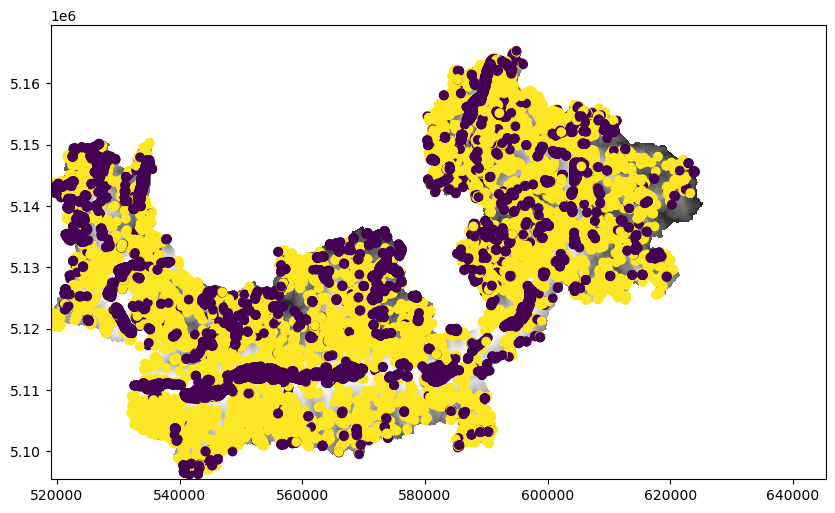

In [86]:
fig, ax = plt.subplots(figsize=(10, 10))
DTM = rasterio.open(".\datasets\dtm.tif")
show(DTM,ax = ax, cmap = 'Greys')
test_data_gpkg.plot(column="Target", ax=ax)
plt.savefig(r'test_map.png', bbox_inches='tight')
plt.show()

the zero in target column is represented by the yellow colour on the map

the one in target column is represented by the purple colour on the map